In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy import stats
import os

In [2]:
def process(f): 
    d = loadmat(f)['AngSpeed_OrientTIP']
    return (d[:, 1]-90)/180*np.pi

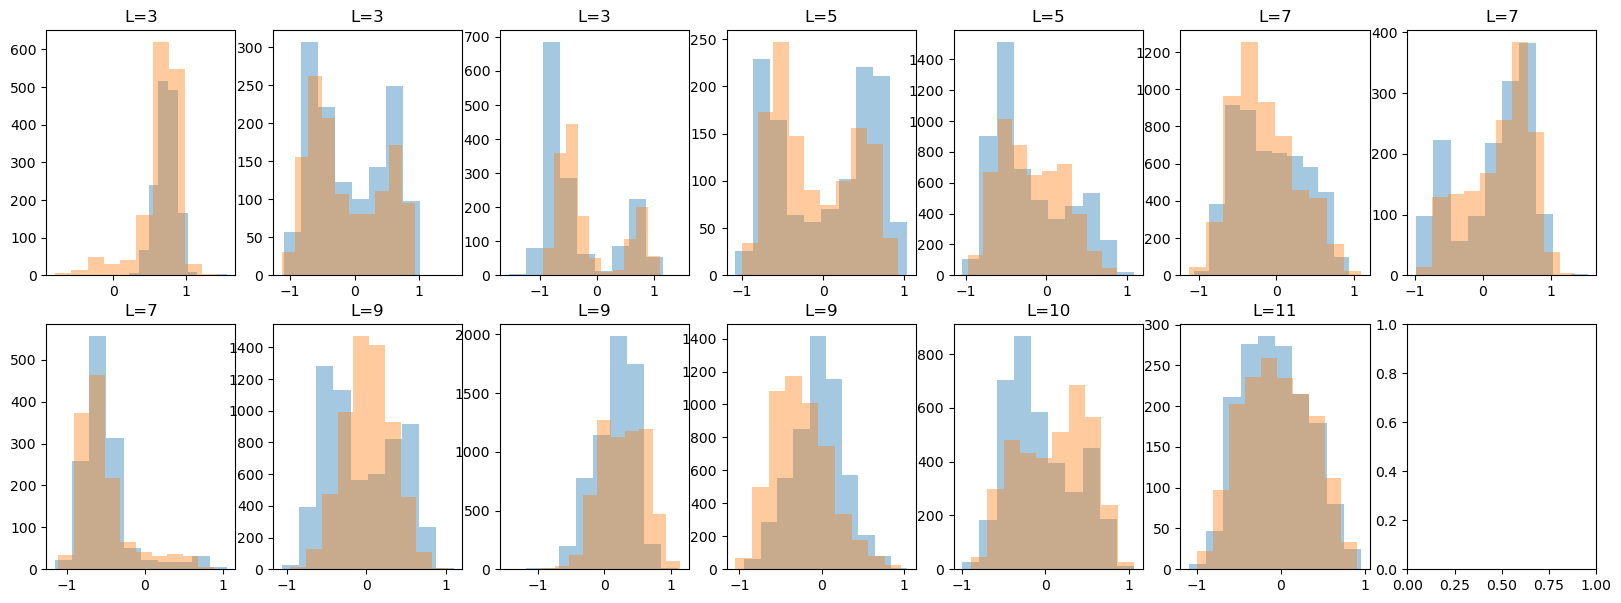

In [8]:
path = 'Data/SpinningRodOrientation/'
filenames = [f for f in os.listdir(path) if f.endswith('2.mat')] 
Ls = [int(f.split('_')[0][1:]) for f in filenames]
Ls, filenames = zip(*sorted(zip(Ls, filenames)))

## pair up the files 
data = [] 

fig, axes = plt.subplots(2, int(len(Ls)/2)+1, figsize=(20, 7))

for (i, f) in enumerate(filenames): 
    p1 = process(path+f) 
    p2 = process(path+f[:-5]+'.mat')

    if len(p1) != len(p2):
        ll = max(len(p1), len(p2))
        if len(p1) < ll: 
            p1 = np.concatenate((p1, p2[len(p1):]))
        else: 
            p2 = np.concatenate((p2, p1[len(p2)-1:]))
    a, b = np.unravel_index(i, (2, int(len(Ls)/2+1)))
    axes[a, b].hist(p1, alpha=0.4)
    axes[a, b].hist(p2, alpha=0.4)
    # axes[a, b].hist(p1+p2/2, facecolor=None)
    axes[a, b].set_title('L={}'.format(Ls[i]))

    data.append(p1+p2)

uni_Ls = sorted(np.unique(Ls))
agg_data = []
for L in uni_Ls: 
    single_length = [d for (d, l) in zip(data, Ls) if l == L]
    agg_data.append(single_length)
Ls = uni_Ls 
data = agg_data 

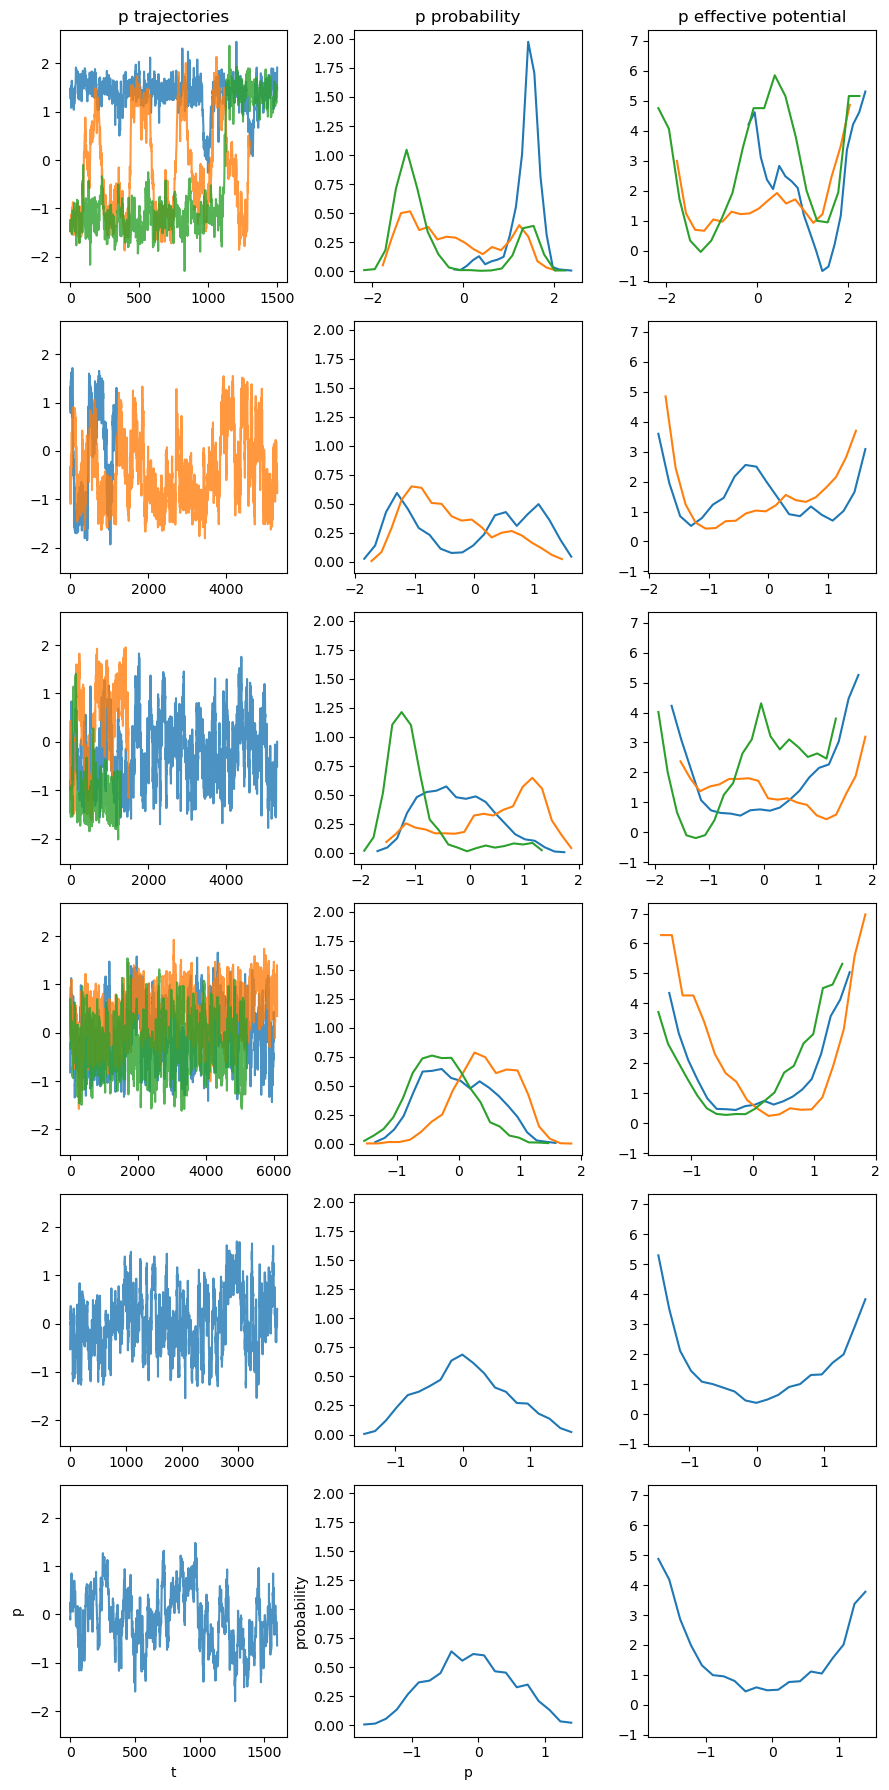

In [76]:
fig, axes = plt.subplots(len(Ls), 3, sharey='col', figsize=(9, 3*len(Ls)))
for (i, (L, d)) in enumerate(zip(Ls, data)): 
    for (j, traj) in enumerate(d): 
        axes[i, 0].plot(traj, alpha=0.8, c=plt.cm.tab10(j))
        counts, bins = np.histogram(traj, bins=20, density=True)
        mids = [(x+y)/2 for (x, y) in zip(bins[:-1], bins[1:])]
        axes[i, 1].plot(mids, counts, '-', c=plt.cm.tab10(j))
        axes[i, 2].plot(mids, -np.log(counts), '-', c=plt.cm.tab10(j))
axes[0, 0].set_title('p trajectories')
axes[0, 1].set_title('p probability')
axes[0, 2].set_title('p effective potential')

axes[-1, 0].set_xlabel('t')
axes[-1, 1].set_xlabel('p')

axes[-1, 0].set_ylabel('p')
axes[-1, 1].set_ylabel('probability')

plt.tight_layout()
plt.show() 

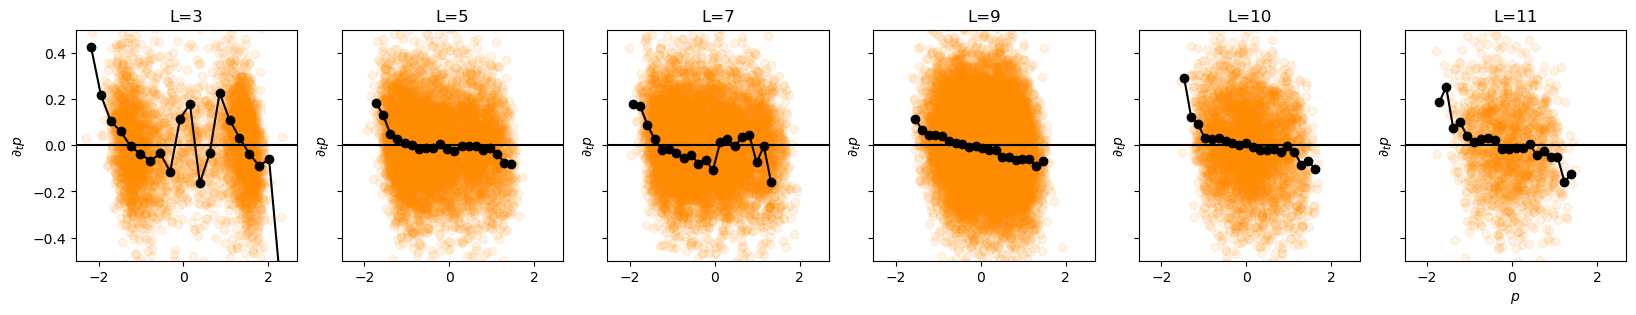

In [77]:
fig, axes = plt.subplots(1, len(Ls), sharex=True, sharey=True, figsize=(20, 3))
for (i, (L, d)) in enumerate(zip(Ls, data)): 
    ps = [] 
    dps = [] 
    for traj in d: 
        p = traj
        axes[i].plot(p[:-1], p[1:]-p[:-1], 'o', alpha=0.1, c='darkorange')
        ps.extend(p[:-1])
        dps.extend(p[1:]-p[:-1])
    val, bins, _ = stats.binned_statistic(p[:-1], p[1:]-p[:-1], bins=20)
    mids = [(x+y)/2 for (x, y) in zip(bins[:-1], bins[1:])]
    axes[i].plot(mids, val, 'o-', c='k')
    axes[i].axhline(y=0, c='k')
    axes[i].set_title('L={}'.format(L))
    axes[i].set_ylabel(r'$\partial_t p$')
axes[0].set_ylim([-0.5, 0.5])
axes[-1].set_xlabel(r'$p$')
plt.show() 

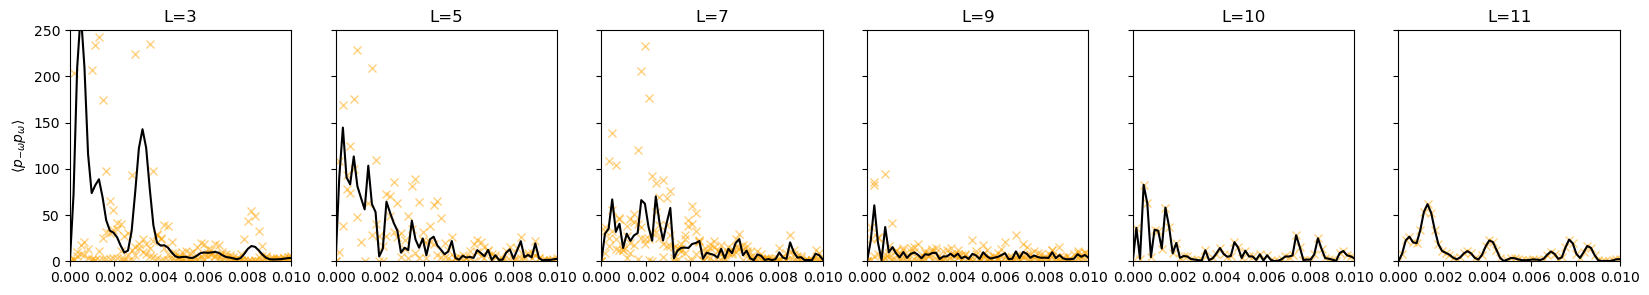

In [78]:
max_length = max([max([len(traj) for traj in d]) for d in data])
w = np.fft.rfftfreq(max_length)

fig, axes = plt.subplots(1, len(Ls), sharex=True, sharey=True, figsize=(20, 3))
for (i, (L, d)) in enumerate(zip(Ls, data)):
    S = np.zeros(int(np.ceil(max_length/2)))
    tot_length = 0 
    for traj in d: 
        p = traj - np.mean(traj)
        tot_length += len(p)
        p_pad = np.pad(p, (0, max_length - len(p)), mode='constant')
        pw = np.fft.rfft(p_pad)
        axes[i].plot(w, np.abs(pw)**2/len(p), 'x', alpha=0.5, c='orange')
        S += np.abs(pw)**2
    axes[i].plot(w, S/tot_length, c='k')
    axes[i].set_title('L={}'.format(L))
axes[i].set_xlim([0, 0.01])
axes[0].set_ylim([0, 250])
axes[0].set_ylabel(r'$\langle p_{-\omega} p_{\omega} \rangle$')
plt.show() 